## __Importando bibliotecas necessárias__

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tfw
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

## __Defina o caminho para as pastas__

In [6]:
pathO = os.getcwd()
path = pathO + "\\produtos_regionais\\"
log_dir = pathO + "\\logsLote"
output_dir_bestModel = pathO + "\\models\\"
output_dir = pathO + "\\modelsLote\\"

['test', 'train', 'val']

## __Criar pasta de Logs__

In [ ]:
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)  # Remove a pasta e todo o conteúdo
    print(f"Pasta existente removida: {log_dir}")

os.makedirs(log_dir)
print(f"Pasta criada: {log_dir}")

## __Criar o callback do TensorBoard__

In [10]:
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
)

## __Configurações de Data Augmentation__

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,         
    rotation_range=10,      
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    shear_range=0.1,        
    zoom_range=0.1,         
    horizontal_flip=True,    
    fill_mode='nearest'     
)

## __Gerando os dados de treino__

In [12]:
train_generator = datagen.flow_from_directory(
    directory=path + 'train',
    target_size=(224, 224),  # Redimensiona as imagens para 224x224 pixels
    class_mode='categorical',
    shuffle=False
)

Found 272 images belonging to 4 classes.


## __Gerando os dados de validação__

In [13]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    directory=path + 'val',
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 64 images belonging to 4 classes.


## __Gerando os dados de teste__

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Apenas normalização, sem augmentação

test_generator = test_datagen.flow_from_directory(
    directory=path + 'test',  # Substitua pelo caminho do diretório de teste
    target_size=(224, 224),          # Redimensiona as imagens para 224x224 pixels
    batch_size=32,                   # Tamanho do lote
    class_mode='categorical',        # Codificação one-hot (ou None se apenas previsões forem necessárias)
    shuffle=False                    # Não embaralha, útil para manter a ordem original
)

Found 124 images belonging to 4 classes.


## __Definindo hiperparâmetros__

In [15]:
epochs_options = [20, 50]
batch_size_options = [16, 32]
learning_rate_options = [0.001, 0.0001]
optimizers_options = [Adam, SGD]

## __Treinando modelo__

In [ ]:
results = []
cont=1
# Loop para treinar modelos com diferentes combinações de hiperparâmetros
for epochs in epochs_options:
    for batch_size in batch_size_options:
        for learning_rate in learning_rate_options:
            for optimizer in optimizers_options:
                try:
                    # Configurando os geradores de dados
                    train_generator.batch_size = batch_size
                    validation_generator.batch_size = batch_size
                    
                    # Criando o modelo com EfficientNetV2B0
                    base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
                    x = base_model.output
                    x = GlobalAveragePooling2D()(x)
                    predictions = Dense(len(train_generator.class_indices), 
                                                        activation='softmax',
                                                        kernel_regularizer=l2(0.001))(x)
                    model = Model(inputs=base_model.input, outputs=predictions)
                    
                    # Compilando o modelo
                    model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                                  loss='categorical_crossentropy', 
                                  metrics=['accuracy'])
                    
                    # Treinando o modelo
                    history = model.fit(
                        train_generator,
                        epochs=epochs,
                        validation_data=validation_generator,
                        callbacks=[tensorboard_callback]
                    )
                    
                    if(cont==1):
                        best_model = model
                        best_epoch = epochs
                        best_batch_size = batch_size
                        best_learning_rate = learning_rate
                        best_optimizer = optimizer.__name__
                    # Avaliando o modelo
                    final_loss, final_accuracy = model.evaluate(validation_generator)
                    best_loss, best_accuracy = best_model.evaluate(validation_generator)
                    if(final_accuracy>best_accuracy):
                        best_model = model
                        best_epoch = epochs
                        best_batch_size = batch_size
                        best_learning_rate = learning_rate
                        best_optimizer = optimizer.__name__
                    # Após o treinamento, armazene as informações no `results`
                    results.append({
                        'epochs': epochs,
                        'batch_size': batch_size,
                        'learning_rate': learning_rate,
                        'optimizer': optimizer.__name__,
                        'final_loss': final_loss,
                        'final_accuuracy': final_accuracy,
                        'loss': history.history['loss'][-1],  # A última perda de treino
                        'accuracy': history.history['accuracy'][-1],  # A última acurácia de treino
                        'val_loss': history.history['val_loss'][-1],  # A última perda de validação
                        'val_accuracy': history.history['val_accuracy'][-1],  # A última acurácia de validação
                        'history': history  # Armazenando o histórico completo
                    })
                    # Salvar o modelo no diretório especificado
                    model_name = f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer.__name__}.h5"
                    model.save(os.path.join(output_dir, model_name), save_format='h5')

                    cont+=1
                except Exception as e:
                    print(f"model_epochs{epochs}_batch{batch_size}_lr{learning_rate}_{optimizer} {e}")

Epoch 1/20
17/17 [==============================] - 65s 3s/step - loss: 1.5400 - accuracy: 0.2279 - val_loss: 1.4140 - val_accuracy: 0.2500
Epoch 2/20
17/17 [==============================] - 46s 3s/step - loss: 1.3319 - accuracy: 0.3713 - val_loss: 1.4056 - val_accuracy: 0.2500
Epoch 3/20


## __Convertendo resultados em DataFrame__

In [ ]:
results_df = pd.DataFrame(results)
folder_path=pathO+"\\resultados\\"
csv_file_path = os.path.join(folder_path, 'results_.csv')
results_df.to_csv(csv_file_path, index=False)
print(results_df)

## __Salvar o melhor modelo separadamente__

In [ ]:
model_name = f"best_model_epochs{best_epochs}_batch{best_batch_size}_lr{best_learning_rate}_{best_optimizer}.h5"
best_model.save(os.path.join(output_dir_bestModel, model_name), save_format='h5')

## __Encontrar o melhor modelo com base na acurácia de validação__

KeyError: 'history'

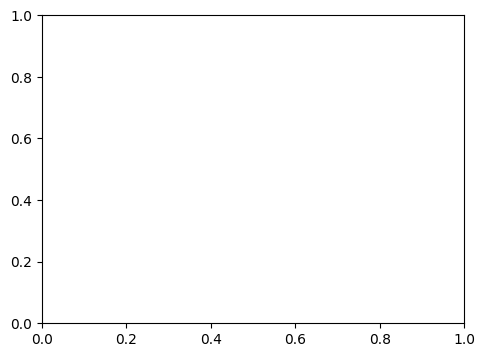

In [24]:
best_accuracy = 0
best_history = None

# Iterar sobre os resultados para encontrar o modelo com a maior val_accuracy
for result in results:
    val_accuracy = result.get('val_accuracy', 0)  # Obtém a acurácia de validação
    
    # Verifica se a acurácia de validação é maior que a atual
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_history = result  # Armazena o histórico do melhor modelo

## __Gerar gráfico do melhor modelo__

In [ ]:
if best_history:
    plt.figure(figsize=(12, 4))
    
    # Gráfico de Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(best_history['history'].history['accuracy'], label='Acurácia Treino')
    plt.plot(best_history['history'].history['val_accuracy'], label='Acurácia Validação', linestyle='--')
    plt.title(f"Acurácia do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()
    
    # Gráfico de Perda
    plt.subplot(1, 2, 2)
    plt.plot(best_history['history'].history['loss'], label='Perda Treino')
    plt.plot(best_history['history'].history['val_loss'], label='Perda Validação', linestyle='--')
    plt.title(f"Perda do Melhor Modelo (Acurácia Validação: {best_accuracy:.4f})")
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()

    # Exibindo os gráficos
    plt.show()
else:
    print("Nenhum modelo foi encontrado.")

## __Gerando a matriz de confusão para o melhor modelo__

In [ ]:
y_true = validation_generator.classes
y_pred = best_model.predict(validation_generator)  # Não precisa de ['model'], apenas use o objeto diretamente
y_pred_classes = np.argmax(y_pred, axis=1)

## __Criando a matriz de confusão__

4/4 [==============================] - 8s 2s/step


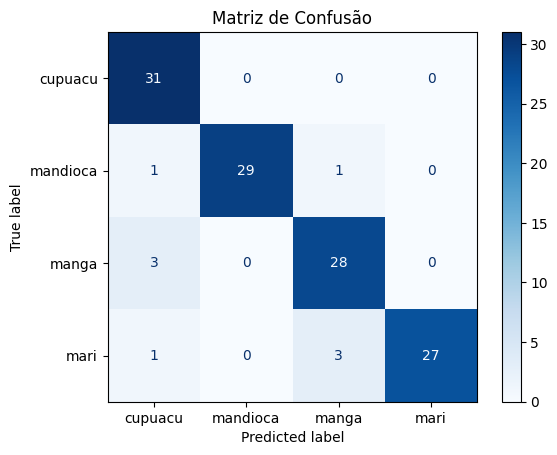

In [25]:
cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.show()

## __Avaliação do modelo com o conjunto de teste__

In [ ]:
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Loss no conjunto de teste: {test_loss}")
print(f"Acurácia no conjunto de teste: {test_accuracy}")

## __Função de Predição__

In [17]:
def predict_image_class(image_path, model, class_indices):
    # Carregar a imagem
    img = load_img(image_path, target_size=(224, 224))  # Redimensiona para o tamanho usado no modelo
    img_array = img_to_array(img)  # Converte para array numpy
    img_array = np.expand_dims(img_array, axis=0)  # Adiciona uma dimensão para lote
    img_array = img_array / 255.0  # Normaliza os valores para o intervalo [0, 1]

    # Previsão
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions, axis=-1)[0]  # Índice da classe com maior probabilidade

    # Mapeando índice para a classe
    class_labels = {v: k for k, v in class_indices.items()}  # Inverte o mapeamento
    predicted_class = class_labels[predicted_class_idx]

    return predicted_class

## __Exemplo de Previsão__

In [28]:
image_path = pathO + "\\to_predict\\cupuacu.jpg"
predicted_class = predict_image_class(image_path, best_model, train_generator.class_indices)
print(f"A imagem pertence à classe: {predicted_class}")

1/1 [==============================] - 0s 62ms/step
A imagem pertence à classe: mari


## __Finalizando o TensorBoard__

In [5]:
%load_ext tensorboard
%tensorboard --logdir .\logsLote